In [1]:
import glob
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

from utils import estimate_frequencies, amplitude_spectrum

In [2]:
from periodogram import Periodogram

In [3]:
# ii = -1
# # df = pd.read_csv("../data/catalogues/rev_AF_stars.csv", dtype={'kic': str})
# koi = pd.read_csv('../transit analysis/cumulative_2021.05.01_20.40.11.csv', dtype={'kepid': str}, skiprows=146)

# # df = pd.merge(df, koi, left_on='kic', right_on='kepid')
# df = koi
# row = df[df.kepid == candidates[ii]].squeeze()
# f = glob.glob(f"../data/lightcurves/spline corrected PDC/lc/*{candidates[ii]}*")[0]
# time, flux, flux_err = np.loadtxt(f, unpack=True)
# flux -= 1.
# plt.plot(time, flux)

In [13]:
from scipy.ndimage import gaussian_filter

def high_pass(t, y, width=3.):
    y_low = gaussian_filter(y, width)
    return y - y_low

def get_kepler_lc(kic_id):
    file = glob.glob(f'../data/lightcurves/PDC/*{kic_id}.csv')[0]
    t, y = np.loadtxt(file, usecols=(0,1)).T
    return t, y
    
def preprocess_lc(t, y):
    y = high_pass(t, y)
    lc = lk.LightCurve(t, y).remove_outliers().remove_nans()
    return lc.time.value, lc.flux.value

In [30]:
cand = pd.DataFrame({
    'kepid': ['4380834', '5724523', '7767699', '8249829', '9895543'],
    'period': [0.889896, 0.545784, 1.128263, 1.012737, 1.218900],
    'nfreqs': [
    2,
    3,
    3,
    1,
    2
]
})

In [31]:
cand

,kepid,period,nfreq
0,4380834,0.889896,2
1,5724523,0.545784,3
2,7767699,1.128263,3
3,8249829,1.012737,1
4,9895543,1.218900,2


/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


kepid     9895543
period     1.2189
Name: 4, dtype: object

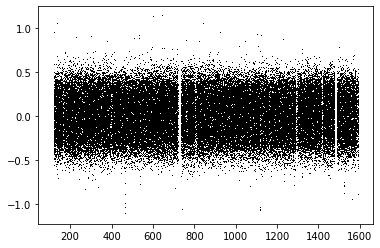

In [28]:
ii = 4

row = cand.iloc[ii]

time, flux = get_kepler_lc(row.kepid)
time, flux = preprocess_lc(time, flux)
flux *= 1e3
# flux *= 1e3
plt.plot(time, flux, ',k')
row

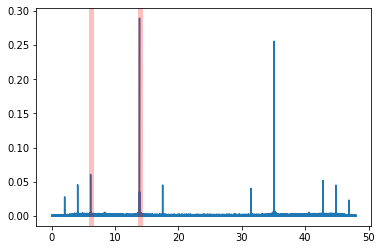

In [29]:
# plt.plot(time, flux)
peaks = estimate_frequencies(time, flux, max_peaks=2)
plt.plot(*amplitude_spectrum(time, flux, fmax=48))
for p in peaks:
    plt.axvline(p, c='red', lw=5, alpha=0.25)
    
amps = np.array([amplitude_spectrum(time, flux, freq=[p])[1] for p in peaks]).squeeze()

In [ ]:
n = [
    2,
    3,
    3,
    1,
    2
]

# First look with a pulsation timing periodogram

In [ ]:
pg = Periodogram(time, flux, peaks)
periods = np.linspace(20, 120, 200)
res = pg.fit(periods)


  0%|          | 1/200 [00:02<07:18,  2.20s/it]

array([<AxesSubplot:xlabel='Period [day]', ylabel='Model likelihood'>,
       <AxesSubplot:xlabel='Period [day]', ylabel='asini (s)'>],
      dtype=object)

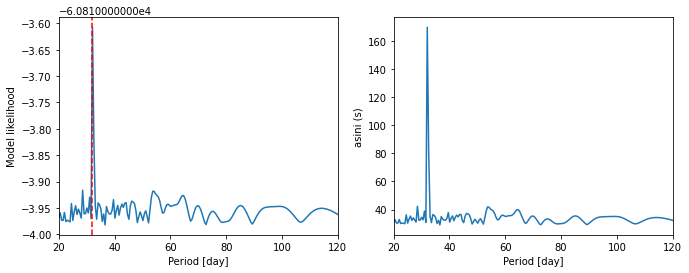

In [10]:
pg.diagnose()

# Pulsation timing model

In [38]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
import exoplanet as xo
import numpy as np


def planet_model(time, flux, freq, amps, period_t, period_sd, eccen_t):
    """A custom PyMC3 model for planetary transits.
    
    Args:
        time (array): Time values
        flux (array): Flux values corresponding to `time`
        freq (array): Frequencies in the pulsation model
        amps (array): Amplitudes in the pulsation model
        period_t (float): Orbital period from the transit
        period_sd (float): Standard deviation of the orbital period from the transit
        eccen_t (float): Eccentricity
    
    Returns:
        PyMC3 Model: A planet pulsation timing model.
    """
    if np.isnan(period_sd):
        period_sd = 1e-5
        
    with pm.Model() as model:
        period = pm.Normal("period", mu=period_t, sd=period_sd, testval=period_t)
        phi = xo.distributions.Angle("phi")
        logs_lc = pm.Normal("logsigma", mu=np.log(np.std(flux)), sd=10, testval=0.0)
        
#         asini = pm.Bound(pm.Flat, lower=0)("asini", shape=len(freq), testval=1e-5 + np.zeros(len(freq)))
        asini = pm.Bound(pm.Flat, lower=0)("asini", testval=1e-5)
        mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)

        # Mean anom
        M = 2.0 * np.pi * time / period - phi

        if eccen_t == 0:
            eccen = 0
            omega = 0
            psi = -tt.sin(M)
        else:
            eccen = pm.Uniform("eccen", lower=1e-3, upper=0.99, testval=eccen_t)
            omega = xo.distributions.Angle("omega", testval=0.0)  # True anom
            kepler_op = xo.theano_ops.kepler.KeplerOp()
            sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

            factor = 1.0 - tt.square(eccen)
            factor /= 1.0 + eccen * cosf
            psi = -factor * (sinf * tt.cos(omega) + cosf * tt.sin(omega))

#         tau = pm.Deterministic("tau", psi * asini)#[:, None])
        tau = psi * asini
#         tau = pm.Deterministic("tau", psi * asini[:, None])
        lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
        nu = pm.Deterministic("nu", tt.exp(lognu))
        factor = 2.0 * np.pi * nu

        arg = (factor * (1))[None, :] * time[:, None] - (factor * asini / 86400)[
            None, :
        ] * psi[:, None]

        phase = xo.distributions.Angle("phase", shape=len(freq))
        logamp = pm.Normal(
            "logamp", mu=np.log(amps), sd=0.01, shape=len(freq), testval=np.log(amps)
        )
#         lc_model = pm.Deterministic('lc',
#             tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
#             + mean
#         )
        lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1) + mean

        # We pass this into our likelihood
        pm.Normal("obs", mu=lc_model, sd=tt.exp(logs_lc), observed=flux)

    return model

model = planet_model(time, flux, peaks, amps, koi_period, koi_period_err, 0)

with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "asini_interval__"]]
    
    map_params = xo.optimize(start=None, vars=[model['mean']])
    map_params = xo.optimize(start=map_params, vars=[model['logsigma']])
    map_params = xo.optimize(start=map_params, vars=[model['phase'], model['logamp']])
    if not koi_eccen == 0:
        map_params = xo.optimize(start=map_params, vars=[model['eccen'], model['omega']])
    map_params = xo.optimize(start=map_params, vars=[model["phi"]])
    map_params = xo.optimize(start=map_params, vars=[model["lognu"]])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[model['asini']])
    map_params = xo.optimize(start=map_params)

optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -62872.8822469147 -> -62872.88213813334


optimizing logp for variables: [logsigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -62872.88213813334 -> -59370.50367471148
optimizing logp for variables: [logamp, phase]


message: Desired error not necessarily achieved due to precision loss.
logp: -59370.50367471148 -> -35318.829850281094
optimizing logp for variables: [phi]


message: Optimization terminated successfully.
logp: -35318.829850281094 -> -35298.372527545565


optimizing logp for variables: [lognu]


message: Desired error not necessarily achieved due to precision loss.
logp: -35298.372527545565 -> -35298.37252723318
optimizing logp for variables: [logamp, phase, lognu, mean, asini, logsigma, phi, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -35298.37252723318 -> 5789.276150826233
optimizing logp for variables: [asini]


message: Optimization terminated successfully.
logp: 5789.276150826233 -> 5789.276150826233


optimizing logp for variables: [logamp, phase, lognu, mean, asini, logsigma, phi, period]


message: Desired error not necessarily achieved due to precision loss.
logp: 5789.276150826233 -> 5789.276150830325


In [43]:
map_params

{'period': array(22.82451391),
 'phi_angle__': array([ 4.07190327, -1.84918854]),
 'logsigma': array(-1.52734289),
 'asini_lowerbound__': array(0.63692828),
 'mean': array(-0.00014431),
 'lognu': array([3.6480037 , 3.59380084, 3.48939368, 3.66066367]),
 'phase_angle__': array([[ 1.67870138,  2.92999927, -4.44626784,  2.85396341],
        [-4.14515395, -3.3788974 ,  0.47987056, -3.44308473]]),
 'logamp': array([-0.81944639, -1.49448161, -1.60657373, -2.20565318]),
 'phi': array(1.99708253),
 'asini': array(1.89066436),
 'nu': array([38.39793554, 36.37205789, 32.76607503, 38.88714266]),
 'phase': array([ 2.7568012 ,  2.42722797, -1.46328587,  2.44947812])}

In [40]:
np.random.seed(1)
with model: 
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_params,
        cores=2,
        chains=2,
        initial_accept=0.8,
        target_accept=0.95,
        return_inferencedata=False,
    )
    
#     pm.save_trace(trace, f'traces/{row.kic}')

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logamp, phase, lognu, mean, asini, logsigma, phi, period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1117 seconds.


In [41]:
import pickle # python3

with open(f'traces/{row.kepoi_name}.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [44]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(0.9866667339213503, 0.9140991338325439)

In [75]:
8**(1/3)

2.0

In [15]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(array([4.5185215 , 2.96175041, 5.94898612]),
 array([3.62995364, 3.04369991, 4.93405612]))

In [15]:
trace["period"]

array([111.65567532, 111.65450607, 111.65485362, ..., 111.6549794 ,
       111.65632722, 111.65423728])

In [20]:
import astropy.units as u
import astropy.constants as const

def mass_function(period, asini):
    """Calculates the mass function for a given system
    
    Args:
        period (astropy.units.quantity.Quantity): Orbital period
        asini (astropy.units.quantity.Quantity): Convolved semi-major axis
    
    Returns:
        astropy.units.quantity.Quantity: Mass function in M_sun
    """
    si = (
        (4 * np.pi ** 2 * (1 * const.c ** 3))
        / (1 * const.G)
        * 1
        / (period.to(u.s) ** 2)
        * (asini ** 3)
    )
    return si#.to(u.M_sun)

def rv_semi_amplitude(period, mf, ecc=0):
    K1 = (
        (2 * np.pi * const.G)**(1/3)
        * np.sqrt(1-ecc**2)
        * (mf.to(u.kg) / period.to(u.s))**(1/3)
    )
    return K1

# mf = mass_function(22*u.day, 0.1*u.s)

In [21]:
rvv = rv_semi_amplitude(trace["period"]*u.day, mass_function(trace["period"]*u.day, trace['asini'][:,0]*u.s)).value

In [22]:
np.median(rvv), np.std(rvv)

(22947.757473699472, 11991.176632840308)

In [23]:
trace["period"]

array([63.07321845, 63.07320977, 63.07330939, ..., 63.0730653 ,
       63.07386671, 63.07337213])

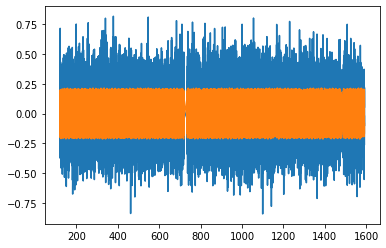

In [44]:
plt.plot(time, flux)
plt.plot(time, lc)

In [16]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
#     logP = pm.Normal("logP", mu=np.log(koi_period), sd=0.1,
#                                       testval=np.log(koi_period))
    period = koi_period#pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=np.log(np.std(flux)))
    
    asini = pm.Uniform('asini', lower=0,
                        upper=100, testval=1e-5, shape=len(freq))

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)   

    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    
    if koi_eccen == 0:
        omega = 0.
        # Eccentricity
        eccen = 0.
        psi = -tt.sin(M)
    else:
        omega = xo.distributions.Angle("omega")
        eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
        # True anom
        kepler_op = xo.theano_ops.kepler.KeplerOp()
        sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

        factor = 1.0 - tt.square(eccen)
        factor /= 1.0 + eccen * cosf
        psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor)[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_mean_amp = np.log(weight)
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
    
    full_lc = lc_model + mean
    pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=flux)

array([10.54114091, 12.56702001, 16.173004  ])